In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset Class
class Fer2013Dataset(Dataset):
    def __init__(self, csv_file, phase, transform=None):
        self.data = pd.read_csv(csv_file)
        self.phase = phase  # 'Training', 'PublicTest', or 'PrivateTest'
        self.transform = transform
        self.data = self.data[self.data['Usage'] == phase]
        self.images = self.data['pixels'].tolist()
        self.labels = self.data['emotion'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = np.fromstring(self.images[idx], dtype=int, sep=' ')
        image = image.reshape(48, 48).astype('uint8')
        image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = Fer2013Dataset(
    csv_file='/home/da23c014/PrivacyAI/CourseProject/datasets/fer2013/fer2013.csv',
    phase='Training',
    transform=train_transform
)

val_dataset = Fer2013Dataset(
    csv_file='/home/da23c014/PrivacyAI/CourseProject/datasets/fer2013/fer2013.csv',
    phase='PublicTest',
    transform=val_transform
)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch.nn as nn

def replace_batchnorm_with_groupnorm(model, num_groups=32):
    """
    Recursively replace all BatchNorm2d layers with GroupNorm in a model.

    Args:
        model (nn.Module): The model in which to replace BatchNorm layers.
        num_groups (int): The number of groups to use in GroupNorm.
    """
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            num_channels = module.num_features
            # Ensure num_groups divides num_channels
            num_groups = min(num_groups, num_channels)
            if num_channels % num_groups != 0:
                # Adjust num_groups if it doesn't divide num_channels
                for ng in reversed(range(1, num_groups)):
                    if num_channels % ng == 0:
                        num_groups = ng
                        break
            gn = nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)
            setattr(model, name, gn)
        else:
            replace_batchnorm_with_groupnorm(module, num_groups=num_groups)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2dWS(nn.Conv2d):
    def forward(self, input):
        # Reshape weight to [out_channels, -1]
        weight_flat = self.weight.view(self.weight.size(0), -1)
        # Compute mean and standard deviation per output channel
        mean = weight_flat.mean(dim=1, keepdim=True)
        std = weight_flat.std(dim=1, keepdim=True) + 1e-5  # Add epsilon for numerical stability
        # Standardize weights
        weight_standardized = (weight_flat - mean) / std
        # Reshape back to original weight shape
        weight_standardized = weight_standardized.view_as(self.weight)
        # Perform convolution with standardized weights
        return F.conv2d(input, weight_standardized, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


In [5]:
def replace_conv_with_convws(module):
    """
    Recursively replace all nn.Conv2d layers with Conv2dWS layers in the given module.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            # Replace with Conv2dWS
            convws = Conv2dWS(
                in_channels=child.in_channels,
                out_channels=child.out_channels,
                kernel_size=child.kernel_size,
                stride=child.stride,
                padding=child.padding,
                dilation=child.dilation,
                groups=child.groups,
                bias=child.bias is not None,
                padding_mode=child.padding_mode
            )
            # Copy the weights and bias
            convws.weight.data = child.weight.data.clone()
            if child.bias is not None:
                convws.bias.data = child.bias.data.clone()
            setattr(module, name, convws)
        else:
            replace_conv_with_convws(child)


In [6]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
num_classes = 7 

# Load pre-trained ResNet-18 model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Replace BatchNorm layers with GroupNorm
replace_batchnorm_with_groupnorm(model, num_groups=32)

# Replace Conv2d layers with Conv2dWS
replace_conv_with_convws(model)


In [7]:
from torch.func import functional_call

# Get model parameters and buffers
params = {k: v.detach() for k, v in model.named_parameters()}
buffers = {k: v.detach() for k, v in model.named_buffers()}


In [8]:
from dp_accounting import dp_event as event
from dp_accounting.rdp import rdp_privacy_accountant as rdp
import numpy as np
from scipy import optimize as opt

# Function to compute the noise multiplier using RDPAccountant
def get_noise_multiplier(epsilon, delta, sampling_rate, steps):
    RDP_ORDERS = (
        [1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 4.5]
        + list(range(5, 64))
        + [128, 256, 512]
    )

    def objective(noise_multiplier):
        accountant = rdp.RdpAccountant(orders=RDP_ORDERS)
        dp_event = event.SelfComposedDpEvent(
            event.PoissonSampledDpEvent(
                sampling_rate, event.GaussianDpEvent(noise_multiplier)
            ),
            steps,
        )
        accountant.compose(dp_event)
        return accountant.get_epsilon(delta) - epsilon

    # Handle cases where the function does not cross zero
    try:
        optimal_noise_multiplier = opt.brentq(objective, 1e-5, 1000, maxiter=1000)
    except ValueError:
        print(f"Could not find a noise multiplier for ε={epsilon}.")
        optimal_noise_multiplier = None
    return optimal_noise_multiplier


In [9]:
# Set the desired large batch size and chunk size
batch_size = 256
chunk_size = 64  # Adjust based on your GPU memory

# Update DataLoader with the large batch size
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)


val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


In [10]:
import torch.nn.functional as F

def loss_fn(outputs, targets):
    return F.cross_entropy(outputs, targets)


In [11]:
from torch.func import functional_call, vmap, grad

# Function to compute loss for each sample
def compute_loss(params, buffers, sample, target):
    outputs = functional_call(model, (params, buffers), sample.unsqueeze(0))
    loss = loss_fn(outputs, target.unsqueeze(0))
    return loss


# Compute the gradient of the loss function with respect to the parameters
ft_compute_grad = grad(compute_loss)
ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0))


In [12]:
# Function to compute per-example gradients
def compute_per_sample_gradients(params, buffers, X_batch, y_batch):
    per_sample_grads = ft_compute_sample_grad(params, buffers, X_batch, y_batch)
    return per_sample_grads


In [13]:
# Function to compute the ℓ2-norm of each gradient
def compute_l2_norm_per_gradient(per_sample_grads):
    l2_norms = torch.stack([
        torch.norm(
            torch.cat([g.flatten() for g in grads]), p=2
        ) for grads in zip(*per_sample_grads.values())
    ])
    return l2_norms

# Function to clip the per-sample gradients to a given norm C
def clip_gradients(per_sample_grads, l2_norms, C=1.0):
    clipped_grads = {}
    clip_factors = torch.clamp(C / (l2_norms + 1e-6), max=1.0)
    for param_name, grads in per_sample_grads.items():
        # Multiply each gradient by the corresponding clipping factor
        clipped_grads[param_name] = grads * clip_factors.view(-1, *([1] * (grads.ndim - 1)))
    return clipped_grads


In [14]:
def dp_sgd_update(params, buffers, X_batch, y_batch, C, sigma, lr, chunk_size):
    """
    Perform one DP-SGD update step with gradient accumulation over chunks.

    Arguments:
    params -- model parameters
    buffers -- model buffers (for functional_call)
    X_batch -- input batch of data (large batch)
    y_batch -- batch of target labels (large batch)
    C -- clipping norm
    sigma -- noise multiplier for the Gaussian noise
    lr -- learning rate for gradient descent
    chunk_size -- size of each chunk (mini-batch) to process at once

    Returns:
    updated_params -- dictionary of updated model parameters
    """
    num_samples = X_batch.size(0)
    num_chunks = (num_samples + chunk_size - 1) // chunk_size  # Ceiling division

    # Initialize accumulated summed gradients
    accumulated_summed_grads = {param_name: torch.zeros_like(param) for param_name, param in params.items()}

    for i in range(num_chunks):
        # Get the current chunk
        start = i * chunk_size
        end = min((i + 1) * chunk_size, num_samples)
        X_chunk = X_batch[start:end]
        y_chunk = y_batch[start:end]

        # Step 1: Compute per-sample gradients for the chunk
        per_sample_grads = compute_per_sample_gradients(params, buffers, X_chunk, y_chunk)

        # Step 2: Compute ℓ2 norm of the gradients
        l2_norms = compute_l2_norm_per_gradient(per_sample_grads)

        # Step 3: Clip the gradients to the norm C
        clipped_grads = clip_gradients(per_sample_grads, l2_norms, C)

        # Step 4: Sum the clipped gradients over the chunk
        for param_name in accumulated_summed_grads:
            accumulated_summed_grads[param_name] += torch.sum(clipped_grads[param_name], dim=0)

    # Step 5: Add Gaussian noise to the accumulated summed gradients
    for param_name in accumulated_summed_grads:
        noise = torch.normal(0, sigma * C, size=accumulated_summed_grads[param_name].shape, device=accumulated_summed_grads[param_name].device)
        accumulated_summed_grads[param_name] += noise

    # Step 6: Average the noisy gradients over the total batch size
    batch_size = X_batch.size(0)
    averaged_grads = {param_name: accumulated_summed_grads[param_name] / batch_size for param_name in accumulated_summed_grads}

    # Step 7: Perform gradient descent step
    updated_params = {param_name: params[param_name] - lr * averaged_grads[param_name] for param_name in params}

    return updated_params


In [15]:
def dp_sgd_update(params, buffers, X_batch, y_batch, C, sigma, lr, chunk_size):
    num_samples = X_batch.size(0)
    num_chunks = (num_samples + chunk_size - 1) // chunk_size  # Ceiling division

    # Initialize accumulated summed gradients
    accumulated_summed_grads = {param_name: torch.zeros_like(param, device=device) for param_name, param in params.items()}

    for i in range(num_chunks):
        # Get the current chunk
        start = i * chunk_size
        end = min((i + 1) * chunk_size, num_samples)
        X_chunk = X_batch[start:end]
        y_chunk = y_batch[start:end]

        # Step 1: Compute per-sample gradients for the chunk
        per_sample_grads = compute_per_sample_gradients(params, buffers, X_chunk, y_chunk)

        # Step 2: Compute ℓ2 norm of the gradients
        l2_norms = compute_l2_norm_per_gradient(per_sample_grads)

        # Step 3: Clip the gradients to the norm C
        clipped_grads = clip_gradients(per_sample_grads, l2_norms, C)

        # Step 4: Sum the clipped gradients over the chunk
        for param_name in accumulated_summed_grads:
            accumulated_summed_grads[param_name] += torch.sum(clipped_grads[param_name], dim=0)

    # Step 5: Add Gaussian noise to the accumulated summed gradients
    for param_name in accumulated_summed_grads:
        noise = torch.normal(0, sigma * C, size=accumulated_summed_grads[param_name].shape, device=accumulated_summed_grads[param_name].device)
        accumulated_summed_grads[param_name] += noise

    # Step 6: Average the noisy gradients over the total batch size
    batch_size = X_batch.size(0)
    averaged_grads = {param_name: accumulated_summed_grads[param_name] / batch_size for param_name in accumulated_summed_grads}

    # Step 7: Perform gradient descent step
    updated_params = {param_name: params[param_name] - lr * averaged_grads[param_name] for param_name in params}

    return updated_params


In [16]:
import numpy as np

# List of ε values
epsilons = [2, 8, 32, 120,500]
ep_vs_acc = {}

n = len(train_dataset)  # Dataset size
delta = 1e-5
batch_size = 256
sampling_rate = batch_size / n
steps = 2400  # Total number of iterations
learning_rate = 0.1 



In [17]:


# For each ε, compute σ and train the model
for epsilon in epsilons:
    # Calculate the noise multiplier σ
    sigma = get_noise_multiplier(epsilon, delta, sampling_rate, steps)
    if sigma is None:
        continue  # Skip if no σ found
    print(f"Calculated noise multiplier (σ): {sigma} for ε: {epsilon}")

    # Reinitialize the model with WS and GN
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    replace_batchnorm_with_groupnorm(model, num_groups=32)
    replace_conv_with_convws(model)
    model = model.to(device)

    # Initialize parameters and buffers
    params = {k: v.detach() for k, v in model.named_parameters()}
    buffers = {k: v.detach() for k, v in model.named_buffers()}

    # Training loop
    total_batches = 0
    model.train()
    while total_batches < steps:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Perform DP-SGD update
            params = dp_sgd_update(params, buffers, data, target, C=1.0, sigma=sigma, lr=learning_rate, chunk_size=chunk_size)

            total_batches += 1
            if total_batches >= steps:
                break  # Stop if we've reached the total number of training steps

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = functional_call(model, (params, buffers), data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    ep_vs_acc[epsilon] = accuracy
    print(f"Test Accuracy for ε={epsilon}: {accuracy:.2f}%")


Calculated noise multiplier (σ): 1.1940571248057474 for ε: 2


/home/da23c014/miniconda3/envs/new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/da23c014/miniconda3/envs/new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy for ε=2: 42.91%
Calculated noise multiplier (σ): 0.6646113864833634 for ε: 8
Test Accuracy for ε=8: 45.33%
Calculated noise multiplier (σ): 0.44166504280521357 for ε: 32
Test Accuracy for ε=32: 46.67%
Calculated noise multiplier (σ): 0.29770437984530645 for ε: 120
Test Accuracy for ε=120: 47.51%
Calculated noise multiplier (σ): 0.22584502328943726 for ε: 500
Test Accuracy for ε=500: 45.81%


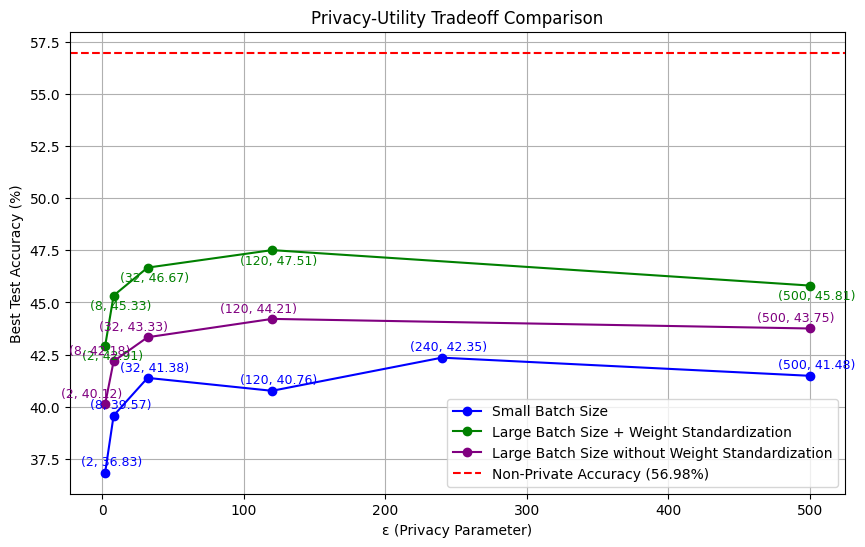

In [1]:
import matplotlib.pyplot as plt

# Data for the first configuration (small batch size)
epsilon_values_small = [2, 8, 32, 120, 240, 500]
best_accuracies_small = [36.83, 39.57, 41.38, 40.76, 42.35, 41.48]

# Data for the second configuration (large batch size with weight standardization)
epsilon_values_large_ws = [2, 8, 32, 120, 500]
best_accuracies_large_ws = [42.91, 45.33, 46.67, 47.51, 45.81]

# Data for the third configuration (large batch size without weight standardization)
epsilon_values_large_no_ws = [2, 8, 32, 120, 500]
best_accuracies_large_no_ws = [40.12, 42.18, 43.33, 44.21, 43.75]  # Replace these values with actual accuracies

# Non-private dataset accuracy
non_private_accuracy = 56.98

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values_small, best_accuracies_small, marker='o', color='blue', label='Small Batch Size')
plt.plot(epsilon_values_large_ws, best_accuracies_large_ws, marker='o', color='green', label='Large Batch Size + Weight Standardization')
plt.plot(epsilon_values_large_no_ws, best_accuracies_large_no_ws, marker='o', color='purple', label='Large Batch Size without Weight Standardization')

# Adding non-private dataset accuracy line
plt.axhline(y=non_private_accuracy, color='red', linestyle='--', label='Non-Private Accuracy (56.98%)')

# Adding titles, labels, and legend
plt.title('Privacy-Utility Tradeoff Comparison')
plt.xlabel('ε (Privacy Parameter)')
plt.ylabel('Best Test Accuracy (%)')
plt.grid(True)
plt.legend()

# Adding markings for each point in all three configurations
for i, (epsilon, accuracy) in enumerate(zip(epsilon_values_small, best_accuracies_small)):
    plt.annotate(f'({epsilon}, {accuracy:.2f})', (epsilon, accuracy), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=9, color="blue")

for i, (epsilon, accuracy) in enumerate(zip(epsilon_values_large_ws, best_accuracies_large_ws)):
    plt.annotate(f'({epsilon}, {accuracy:.2f})', (epsilon, accuracy), textcoords="offset points", xytext=(5, -10), ha='center', fontsize=9, color="green")

for i, (epsilon, accuracy) in enumerate(zip(epsilon_values_large_no_ws, best_accuracies_large_no_ws)):
    plt.annotate(f'({epsilon}, {accuracy:.2f})', (epsilon, accuracy), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=9, color="purple")

plt.show()
